In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import bambi as bmb
import arviz as az

In [5]:
concrete = pd.read_csv('concrete_data.csv')
concrete.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Bayesian Model

Exploratory Data Analysis

In [44]:
print(concrete.isna().any())
print(concrete.dtypes)

cement              False
slag                False
fly_ash             False
water               False
superplasticizer    False
coarse_aggregate    False
fine_aggregate      False
age                 False
strength            False
dtype: bool
cement              float64
slag                float64
fly_ash             float64
water               float64
superplasticizer    float64
coarse_aggregate    float64
fine_aggregate      float64
age                   int64
strength            float64
dtype: object


We don't have any missing values waht is good.

We will not, for now, worriying with eventual Outliers

Our Bayesian will be as it follows

In [46]:
model_pre = 'strength ~ cement + slag + fly_ash + water + superplasticizer + coarse_aggregate + fine_aggregate + age'

As you can understand we have to standardize our variables, if not the results that we will have with Bayesian inference will not be good and our model will be worthless.

In [53]:
model_pre = """strength ~ scale(cement) +
            scale(slag) + scale(fly_ash) + scale(water) + scale(superplasticizer) 
            + scale(coarse_aggregate) + scale(fine_aggregate) + scale(age)"""

model = bmb.Model(model_pre, concrete)
model.build()

Let's plot the priors. This coefficients are what the Model think they should be before it sees the dataset.

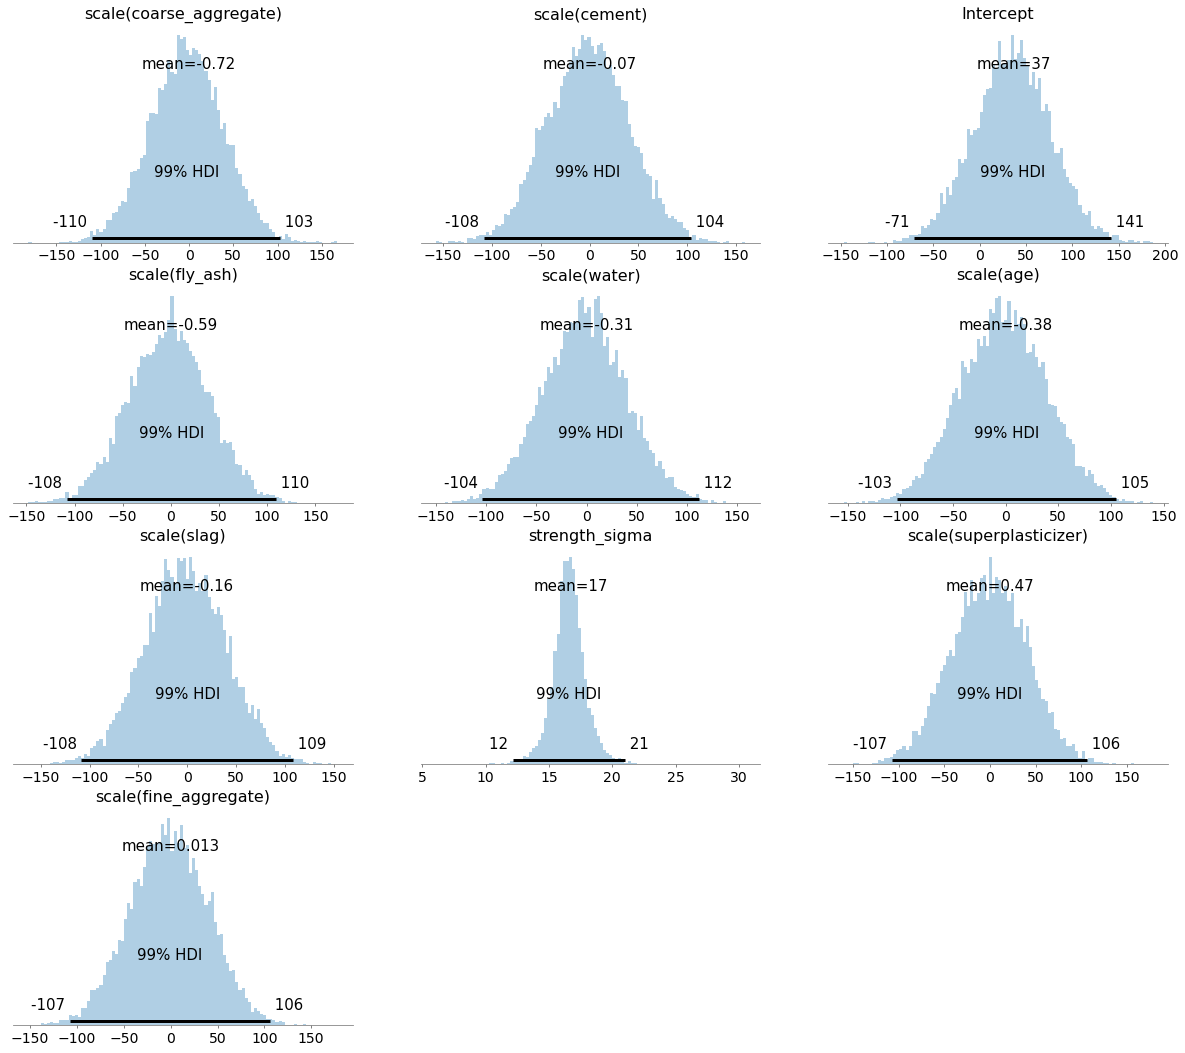

In [56]:
model.plot_priors(draws=10_000, hdi_prob=.99, kind='hist', bins=100)
plt.show()

This looks good enough. Most of our predictors are hovering 0, what is very good.

## Fit the Model

In [65]:
posterior_fit = model.fit(draws = 2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, scale(cement), scale(slag), scale(fly_ash), scale(water), scale(superplasticizer), scale(coarse_aggregate), scale(fine_aggregate), scale(age), strength_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 881 seconds.


After fitting the model let's check our posteriors.

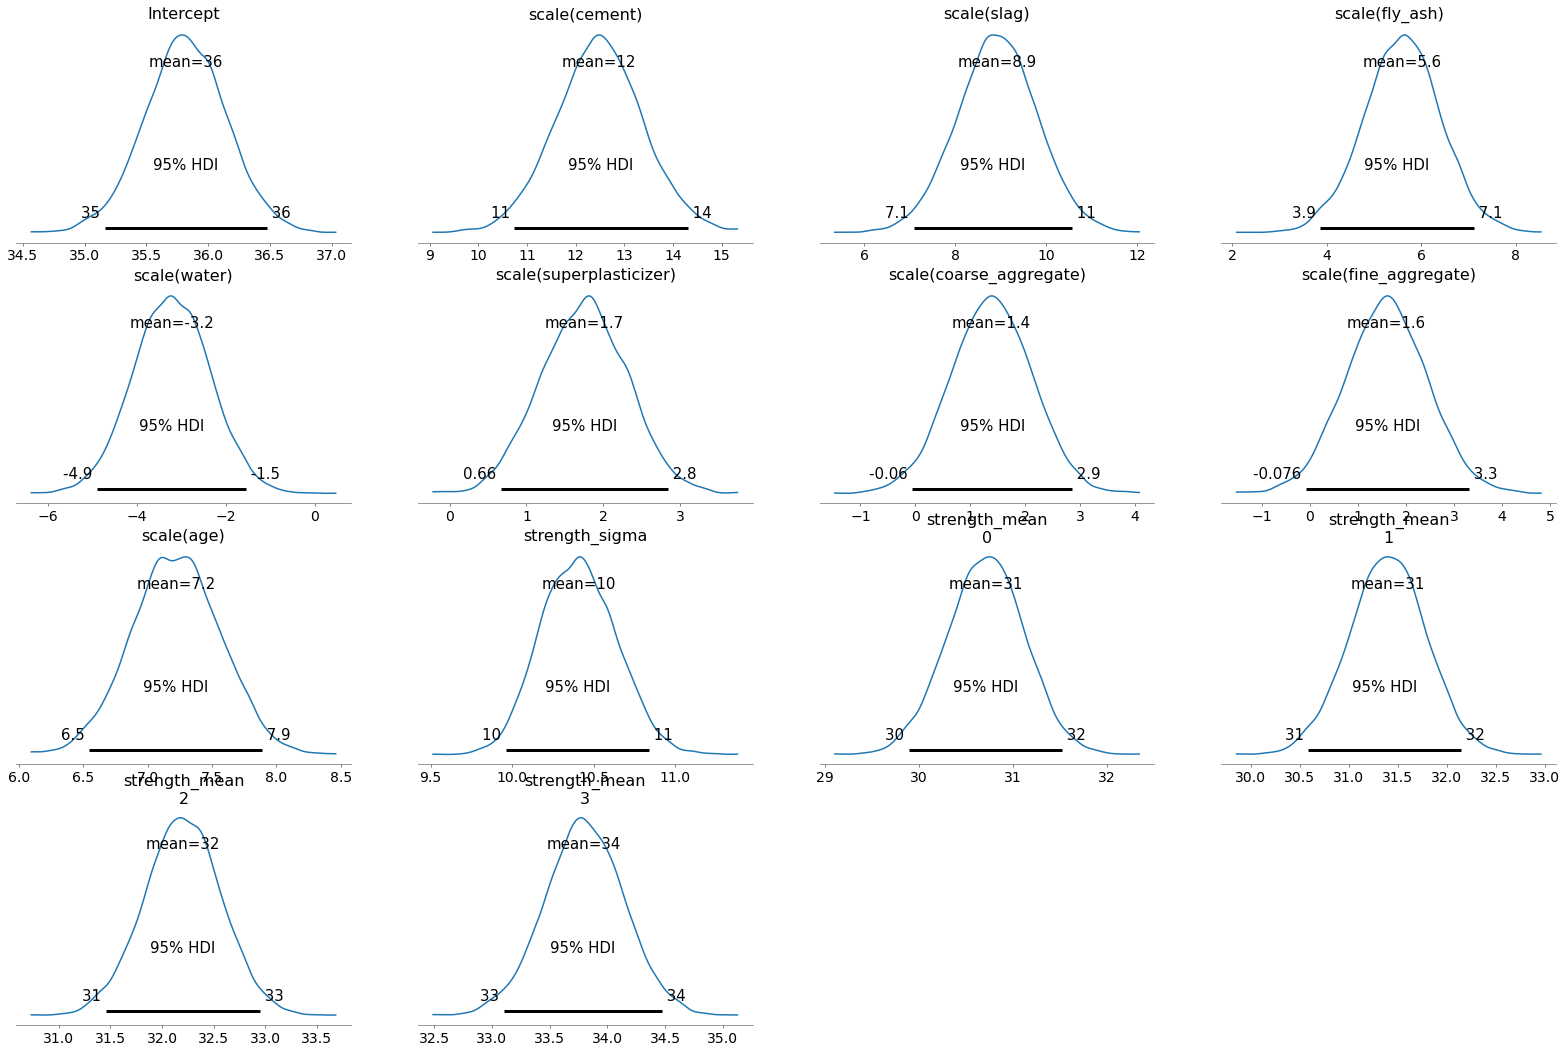

In [104]:
az.plot_posterior(posterior_fit, hdi_prob = 0.95)
plt.show()

To finalize let's predict the posteriors and verify if our posteriors predictions follow the data satisfactory

<AxesSubplot:xlabel='strength / strength'>

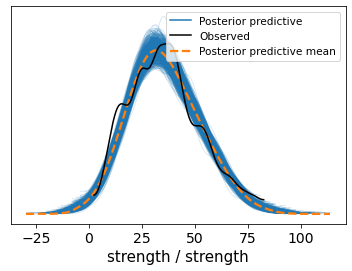

In [67]:
# Conduct a posterior predictive check
model.predict(posterior_fit, kind='pps')

# And plot
az.plot_ppc(posterior_fit, num_pp_samples=1000)

Analyzing the plot we conclude that our predictions are very close to the data observed.

So we are in conditions of predict answer the questions.

First we will compute the mean of our variables without Age that we want to predict and strength.

In [76]:
to_predict = concrete.drop(columns=['age','strength']).mean().to_frame().T
to_predict

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate
0,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883


Then we will multiply the number of rows by four and assign the 4 values that we want to predict

In [77]:
to_predict = (pd.concat([to_predict] * 4, ignore_index=True).assign(age = [1, 7, 14, 28]))
to_predict

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,1
1,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,7
2,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,14
3,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,28


Now we will predict with the posteriors that we calculate when fit the model to the data.

But this time using the new data set 'to_predict'.

In [103]:
mean_predictions = model.predict(posterior_fit, kind='mean', data=to_predict, inplace=False)

Now we will select predictions for strength, stacking the number of chains and draws for the 40000 draws that we have.

After we will merge the dataframe 'to_predict' in the colum, and chcange the name of the columns

In [86]:
means = (mean_predictions['posterior']['strength_mean'].stack(draws=('chain', 'draw')).to_dataframe().reset_index()
         .merge(to_predict[['age']], left_on='strength_obs', right_index=True)
         .pivot(index=['chain', 'draw'], columns='age', values='strength_mean')
        )

means.head()

age                1          7          14         28
chain draw                                            
0     0     30.805553  31.529765  32.374679  34.064507
      1     30.133037  30.839464  31.663629  33.311959
      2     30.458377  31.164158  31.987569  33.634391
      3     30.380419  31.091654  31.921427  33.580975
      4     30.290981  31.020036  31.870600  33.571729

To finalize we will calculate the mean for every prediction that we did for this dataset

In [102]:
means.mean()

age
1     30.712076
7     31.398016
14    32.198279
28    33.798805
dtype: float64

To conclude we should expect streng of,

1 day = 30.712076

7 days = 31.398016

14 days = 32.198279

28 days = 33.798805